In [1]:
import platform
import pandas as pd
import json, csv
import pickle
from datetime import datetime
from operator import itemgetter
from pprint import pprint
import importlib
import itertools
from copy import deepcopy
import numpy as np
import math, time, collections, os, errno, sys, code, random
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import shutil
import configparser
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
N = 3
t_w = 3

In [3]:
A = [[0, 1, 0, 0, 0, 0, 0, 0 ,0], [1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0]]
A_eigenvalue, A_eigenvector = np.linalg.eig(A)
# print("A_eigenvalue: \n" + str(A_eigenvalue))
# print("A_eigenvector: \n" + str(A_eigenvector))
c = min(A_eigenvalue)
print(c)
theta = A + (0.1 + c) * np.identity(N * t_w)
theta_i = np.linalg.inv(theta)
print(theta_i)

-2.0471711259993457
[[-0.49169357  0.04258848  0.20592664  0.346822    0.67532179  0.36869398
   0.35838594  0.49191211  0.59945111]
 [ 0.04258848  0.08292705  0.40097441  0.67532179  1.3149671   0.71791027
   0.69783875  0.95783705  1.1672339 ]
 [ 0.20592664  0.40097441 -0.2305386   0.59945111  1.1672339   0.80537776
   0.15012748  0.5228625   0.86797528]
 [ 0.346822    0.67532179  0.59945111 -0.49169357  0.04258848  0.36869398
   0.49191211  0.35838594  0.20592664]
 [ 0.67532179  1.3149671   1.1672339   0.04258848  0.08292705  0.71791027
   0.95783705  0.69783875  0.40097441]
 [ 0.36869398  0.71791027  0.80537776  0.36869398  0.71791027  0.22382241
   0.85029804  0.85029804  0.80537776]
 [ 0.35838594  0.69783875  0.15012748  0.49191211  0.95783705  0.85029804
  -0.40551485  0.06026571  0.5228625 ]
 [ 0.49191211  0.95783705  0.5228625   0.35838594  0.69783875  0.85029804
   0.06026571 -0.40551485  0.15012748]
 [ 0.59945111  1.1672339   0.86797528  0.20592664  0.40097441  0.80537776
  

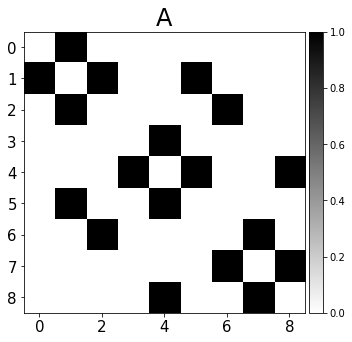

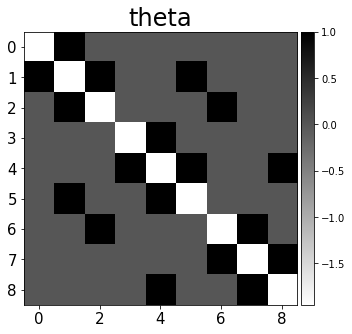

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))
img = ax.imshow(A, cmap='gray_r')
ax.set_yticks([i for i in range(len(A))])
ax.tick_params(labelsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title("A", fontsize = 24)
fig.colorbar(img, cax=cax)
plt.tight_layout(h_pad=1)

# -------------------------------------------------------------------

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5))
img = ax.imshow(theta, cmap='gray_r')
ax.set_yticks([i for i in range(len(theta))])
ax.tick_params(labelsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_title("theta", fontsize = 24)
fig.colorbar(img, cax=cax)
plt.tight_layout(h_pad=1)

In [5]:
import numpy as np

##Parameters to play with

t_w = 3
N = 3
T = 200
# K = 3
# seg_ids = [0, 1, 2, 0, 1, 2]
K = 1
seg_ids = [0]
break_points = []
for i in range(len(seg_ids)):
    break_points.append(i+1)
break_points = np.asarray(break_points) * T
###########################################################

############GENERATE POINTS
cluster_mean = np.zeros([N,1])
cluster_mean_stacked = np.zeros([N * t_w,1])

##Generate two inverse matrices
cluster_covariances = {}
for cluster in range(K):
    cluster_covariances[cluster] = theta

pprint(cluster_covariances)

{0: array([[-1.94717113,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        , -1.94717113,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        , -1.94717113,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.94717113,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        , -1.94717113,
         1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        -1.94717113,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        , -1.94717113,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        

In [6]:

## data matrix
data = np.zeros([break_points[-1],N])
data_stacked = np.zeros([break_points[-1]-t_w+1, N*t_w])
cluster_point_list = []
for counter in range(len(break_points)):
    break_pt = break_points[counter]
    cluster = seg_ids[counter]
    print(cluster)
    if counter == 0:
        old_break_pt = 0
    else:
        old_break_pt = break_points[counter-1]
    for num in range(old_break_pt,break_pt):
        ##generate the point from this cluster
        # print("num is:", num)
        if num == 0:
            cov_matrix = cluster_covariances[cluster][0:N,0:N]##the actual covariance matrix
            new_mean = cluster_mean_stacked[N*(t_w-1):N*t_w]
            ##Generate data	
            new_row = np.random.multivariate_normal(new_mean.reshape(N),cov_matrix)
            data[num,:] = new_row

        elif num < t_w:
            ##The first section
            cov_matrix = cluster_covariances[cluster][0:(num+1)*N,0:(num+1)*N] ##the actual covariance matrix
            n = N
            Sig22 = cov_matrix[(num)*n:(num+1)*n,(num)*n:(num+1)*n] 
            Sig11 = cov_matrix[0:(num)*n,0:(num)*n]
            Sig21 = cov_matrix[(num)*n:(num+1)*n,0:(num)*n]
            Sig12 = np.transpose(Sig21)
            cov_mat_tom = Sig22 - np.dot(np.dot(Sig21,np.linalg.inv(Sig11)),Sig12) #sigma2|1
            log_det_cov_tom = np.log(np.linalg.det(cov_mat_tom))# log(det(sigma2|1))
            inv_cov_mat_tom = np.linalg.inv(cov_mat_tom)# The inverse of sigma2|1

            ##Generate data
            a = np.zeros([(num)*N,1])
            for idx in range(num):
                a[idx*N:(idx+1)*N,0] = data[idx,: ].reshape([N])
            new_mean = cluster_mean + np.dot(np.dot(Sig21,np.linalg.inv(Sig11)),(a - cluster_mean_stacked[0:(num)*N,:]) )
            new_row = np.random.multivariate_normal(new_mean.reshape(N),cov_mat_tom)
            data[num,:] = new_row

        else:
            cov_matrix = cluster_covariances[cluster]##the actual covariance matrix
            n = N
            Sig22 = cov_matrix[(t_w-1)*n:(t_w)*n,(t_w-1)*n:(t_w)*n] 
            Sig11 = cov_matrix[0:(t_w-1)*n,0:(t_w-1)*n]
            Sig21 = cov_matrix[(t_w-1)*n:(t_w)*n,0:(t_w-1)*n]
            Sig12 = np.transpose(Sig21)
            cov_mat_tom = Sig22 - np.dot(np.dot(Sig21,np.linalg.inv(Sig11)),Sig12) #sigma2|1
            log_det_cov_tom = np.log(np.linalg.det(cov_mat_tom))# log(det(sigma2|1))
            inv_cov_mat_tom = np.linalg.inv(cov_mat_tom)# The inverse of sigma2|1

            ##Generate data
            # print("shape of the inv_cov_mat_tom is:", inv_cov_mat_tom.shape)
            # print("cov_mat_tom", cov_mat_tom.shape)
            # print("Sig11 shape", Sig11.shape)

            a = np.zeros([(t_w-1)*N,1])
            for idx in range(t_w-1):
                a[idx*N:(idx+1)*N,0] = data[num - t_w + 1 + idx,: ].reshape([N])
            # print("shape cluster_mean stacked is:", (cluster_mean_stacked[0:(num)*N,:]).shape)
            # print("shape of a is", (a).shape# - cluster_mean_stacked[0:(num)*N,0]).shape)

            new_mean = cluster_mean + np.dot(np.dot(Sig21,np.linalg.inv(Sig11)),(a - cluster_mean_stacked[0:(t_w-1)*N,:]) )
            # print("shape of new_mean is:", new_mean.shape)
            # print("new mean is:", new_mean)
            # print("N:", N)

            new_row = np.random.multivariate_normal(new_mean.reshape(N),cov_mat_tom)
            data[num,:] = new_row

print("done with generating the data!!!")

print("length of generated data is:", data.shape[0])
print(data.shape)

np.savetxt("Synthetic data Matrix rand_seed =[0,1] generated2.csv", data, delimiter=",", fmt='%1.4f')

0
done with generating the data!!!
length of generated data is: 200
(200, 3)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: covariance is not positive-semidefinite.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: covariance is not positive-semidefinite.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: covariance is not positive-semidefinite.
